In [9]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization, Conv1D, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from src.helper_functions import plot_reconstruction
import seaborn as sns


In [15]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=32,
    sample_size=10000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,128))


Found 9800 files for Training set
Found 200 files for Test set


In [3]:
img_width = 128
img_height = 128
kernel_size = 5
strides = 2

In [63]:
class Time_Freq_Autoencoder_Builder:
    
    def build(width, height, depth, filters=(32,64,128,256), latent_dim=256, kernel_size=5):
        
        strides = 2
        
        input_shape = (height, width, depth)
        inputs = Input(shape = input_shape)
        
        chan_dim = -1
        
        x_time = Reshape(target_shape=(height,width))(inputs)
        x_freq = Reshape(target_shape=(height,width))(tf.transpose(inputs, perm=[0,2,1,3]))
        
        for f in filters:
            
            x_time = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_time)
            x_time = BatchNormalization(axis=chan_dim)(x_time)
            
        x_time = Flatten()(x_time)
        latent_time = Dense(latent_dim//2)(x_time)
        
        for f in filters:
            
            x_freq = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_freq)
            x_freq = BatchNormalization(axis=chan_dim)(x_freq)
            
        x_freq = Flatten()(x_freq)
        latent_freq = Dense(latent_dim//2)(x_freq)
        
        
        latent_concat = tf.keras.layers.Concatenate(axis=1)([latent_time, latent_freq])
        
        encoder = Model(inputs, latent_concat, name='encoder')
        
        latent_inputs = Input(shape=((latent_dim//2)*2))
        
        x = Dense(16384, activation='relu')(latent_inputs)
        x = Reshape(target_shape=(8,8,256))(x)
        
        for f in filters[::-1]:
            
            x = Conv2DTranspose(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
            x = BatchNormalization(axis=chan_dim)(x)
            
        x = Conv2DTranspose(depth, kernel_size=kernel_size, padding='same', activation='sigmoid')(x)
        
        outputs = x
        
        decoder = Model(latent_inputs, outputs, name='decoder')
        
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        return (encoder, decoder, autoencoder)
    

class Time_Freq_Autoencoder(tf.keras.Model):
    
    def __init__(self, image_width, image_height, image_depth=1, latent_dim=256, kernel_size=5):
        super().__init__()
        
        self.encoder, self.decoder, self.autoencoder = Time_Freq_Autoencoder_Builder.build(width=image_width, height=image_height, depth=image_depth, latent_dim=256, kernel_size=kernel_size)
        
    def call(self, x):
        autoencoded = self.autoencoder(x)
        return autoencoded
    
autoencoder = Time_Freq_Autoencoder(image_width=img_width, image_height=img_height, latent_dim=256, kernel_size=5)

In [64]:
opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [65]:
autoencoder.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.transpose_10 (TFO  (None, 128, 128, 1)  0          ['input_19[0][0]']               
 pLambda)                                                                                         
                                                                                                  
 reshape_28 (Reshape)           (None, 128, 128)     0           ['input_19[0][0]']               
                                                                                            

In [66]:
hist_2 = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=15,
                       validation_data=data_gen.test)

Epoch 1/15
306/306 [==============================] - 192s 626ms/step - loss: 0.0108 - val_loss: 0.0137
Epoch 2/15
306/306 [==============================] - 189s 615ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 3/15
306/306 [==============================] - 186s 608ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 4/15
306/306 [==============================] - 189s 618ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 5/15
306/306 [==============================] - 185s 604ms/step - loss: 0.0072 - val_loss: 0.0077
Epoch 6/15
306/306 [==============================] - 186s 606ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 7/15
306/306 [==============================] - 182s 594ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 8/15
306/306 [==============================] - 183s 599ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 9/15
306/306 [==============================] - 186s 607ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 10/15
306/306 [==============================] - 191s 623m

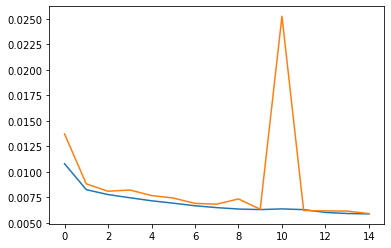

In [67]:
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']
plt.plot(range(len(loss)), loss)
plt.plot(range(len(val_loss)), val_loss)

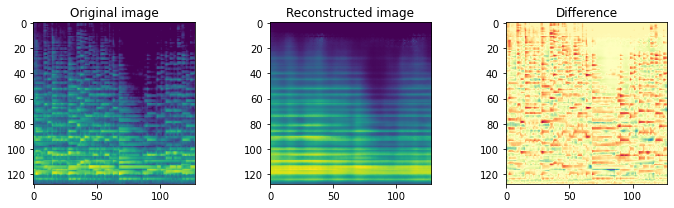

In [68]:
test_img = data_gen.take(1)[0]
prediction = autoencoder(test_img)

plot_reconstruction(test_img, prediction, 1)

In [69]:
autoencoder_path = 'data/autoencoder_256dim_time_freq'
autoencoder.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_256dim_time_freq/assets


INFO:tensorflow:Assets written to: data/autoencoder_256dim_time_freq/assets


In [76]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather', latent_dims=256, output_size=(128, 128)
                        )

Found 278326 files for Generator set


In [77]:
latent_space.build()

try:
    os.mkdir('data/autoencoder_256dim_time_freq')
except:
    pass
latent_space.save('data/autoencoder_256dim_time_freq')

Getting predictions from autoencoder...
[============================================================>] 8697 / 8697

15.95 minutes elapsed
Building tracks dataframe...
size of results 1113216
Track dataframe built. 94.56 minutes elapsed
Building artist distributions...
Artist distributions built. 0.01 minutes elapsed
Building genre distributions...
Genre distributions built. 4.44 minutes elapsed
Latent Space Built.


In [73]:
latent_space.tracks

,id,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19,latent_20,latent_21,latent_22,latent_23,latent_24,latent_25,latent_26,latent_27,latent_28,latent_29,latent_30,latent_31,latent_32,latent_33,latent_34,latent_35,latent_36,latent_37,latent_38,...,latent_226,latent_227,latent_228,latent_229,latent_230,latent_231,latent_232,latent_233,latent_234,latent_235,latent_236,latent_237,latent_238,latent_239,latent_240,latent_241,latent_242,latent_243,latent_244,latent_245,latent_246,latent_247,latent_248,latent_249,latent_250,latent_251,latent_252,latent_253,latent_254,latent_255,track_id,track_name,track_preview_link,track_popularity,track_uri,artist_name,artist_id,artist_genres,artist_popularity,release_date
0,003HW8J9GPS5RcJoUxglq6,0.253730,-1.800509,-0.175408,-0.208008,-1.340523,0.799746,-0.828179,0.932293,1.190708,0.308065,-0.412463,-0.204991,-0.046669,-0.797463,0.289492,0.224487,-0.373748,1.651525,0.133671,-1.019650,0.026805,-1.496925,-0.621164,-2.150822,0.135798,0.951326,-0.381985,-1.476055,-0.649332,-1.696573,0.378560,0.238479,0.102941,-0.572629,-0.773842,-0.780320,-1.331412,-0.444470,-0.219967,...,-0.422128,0.410966,-1.146670,0.903871,2.362149,-0.764005,-0.978386,-1.005752,0.229833,0.943997,0.341511,0.983086,0.580661,-0.079053,-0.017072,1.763347,0.907347,-1.831954,-0.112824,-2.355390,0.526582,0.174522,-0.238852,0.166888,1.692328,0.645603,-1.377589,0.774951,1.127146,1.254557,003HW8J9GPS5RcJoUxglq6,Sundarakand,https://p.scdn.co/mp3-preview/3b754613602d0966...,2,spotify:track:003HW8J9GPS5RcJoUxglq6,Hanuman Foundation,5BqH7NG5CzeijCfOyEMMWn,[],3,2001-06-12
1,004FJ19hdlez4imry14FU7,-1.097099,-1.719278,-0.561026,0.486706,0.921449,-0.599054,0.551841,0.431141,-0.493846,-0.556490,-0.085535,0.821571,0.530983,0.066227,1.014243,-0.245896,-1.168101,-1.029935,0.058565,-0.369804,0.196602,0.147227,0.494581,0.007700,-0.307830,-0.129314,-0.699807,0.318846,0.063172,0.976744,-0.089761,-0.054543,-0.312628,0.164933,0.178163,-0.685311,-1.967347,0.335767,-0.039022,...,0.194073,-0.247038,0.508503,0.335573,-0.041245,0.061712,0.015084,0.135016,0.392948,0.007546,-0.272379,1.061026,0.351219,-0.472500,-1.294184,0.485798,-0.946971,0.124538,0.369253,-0.659572,-0.063209,0.664497,-0.007215,0.886549,-0.727332,0.068789,-0.270945,0.139030,-0.734379,0.369434,004FJ19hdlez4imry14FU7,Near,https://p.scdn.co/mp3-preview/2f57f89ab1a722f6...,40,spotify:track:004FJ19hdlez4imry14FU7,Set Mo,2rv8IrcIQiFKkdvQAgUTZj,[aussietronica],45,None
2,009G1RDIr3UgPrFzOPJPfb,1.127787,0.143175,0.216910,-0.246788,0.599693,1.094561,-0.228780,1.451134,1.377875,1.206363,-0.688622,0.737041,-0.412237,1.434271,-1.517482,0.609192,0.077960,0.370243,0.181636,-0.819592,0.188360,0.396800,-1.597636,-1.910230,0.638812,-0.373055,1.568135,0.111778,0.675637,-0.313782,-0.401853,0.085097,-0.680934,0.844066,-0.084022,0.711843,0.132115,-0.958019,-0.119501,...,0.603175,1.009172,0.122707,0.259147,0.967966,1.267792,0.894575,-1.170836,-1.665973,-1.128239,-1.470853,-0.927527,0.091169,0.465466,-0.576335,0.102858,1.564564,0.887918,1.024250,-2.078269,0.757364,0.289167,-1.187413,0.964006,-0.954426,1.925253,-0.838668,1.049199,2.076983,3.022138,009G1RDIr3UgPrFzOPJPfb,5' O'clock In the Morning,https://p.scdn.co/mp3-preview/9f4c8dc080aea750...,35,spotify:track:009G1RDIr3UgPrFzOPJPfb,Village People,0dCKce6tJJdHvlWnDMwzPW,[disco],60,None
3,00Azf0qdLHNyqr5AkDFCgj,-0.120327,0.834443,-1.356138,0.845571,2.007202,-0.330080,1.528299,0.834347,-1.825298,0.210745,2.144863,0.479575,0.494784,-1.459572,-1.946572,-1.879122,0.606461,-1.276531,0.803599,-1.746109,-1.149922,0.769700,0.291247,1.993388,-0.538236,0.720564,2.964863,-1.652379,-1.087122,1.862535,1.986032,-1.793423,0.849399,0.136194,-1.016299,-1.884179,0.585737,1.879800,-1.738572,...,1.680069,-1.457560,2.153373,-0.396765,1.766087,-1.928150,-2.624849,-0.661433,-0.137701,0.333793,-3.052150,-1.834415,-2.768676,-0.342673,0.064032,-1.593754,-2.1860

In [111]:
latent_space.tracks[latent_space.tracks.artist_name.str.contains('Pérez Prado')][['track_id','track_name','artist_name']]

,track_id,track_name,artist_name
57953,1caIyurPdAPvl9kUyNfwir,Cerezo Rosa - Remastered,Pérez Prado
68623,1uwSOYXZoxgSqhn8FIkfH1,Que Rico Mambo,Pérez Prado
93410,2bwhOdCOLgQ8v6xStAqnju,Patricia,Pérez Prado
131130,3fQLXoRwKQTnThncdMCqwG,Mambo No 5,Pérez Prado
148651,4A0iCzLqX0bmDuDq1YAT59,El Manicero,Pérez Prado
188065,5GSxiQq6wuTKUTZqw73L99,Norma la de Guadalajara,Pérez Prado


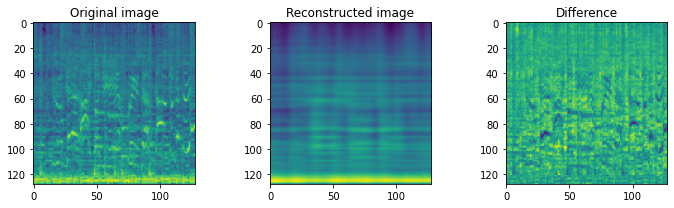

,index,track_name,artist_name,track_uri,similarity
0,1,Mi Yo Cabrón,TéCanela,spotify:track:000OMqK65Cse2zeUoomUfy,1.000000
1,98007,Love Constructor,ElectroGorilla,spotify:track:2k25Y9bMykNGBkxt5chnXI,0.449954
2,3016,Paillardes party (medley),Camping Orchestra,spotify:track:05CNVgYcdcPiMX8x5ZihC8,0.441628
3,81323,Forest Trails,Windy & Carl,spotify:track:2Gvy4DbDM6NQ5rUJDljXz4,0.425935
4,111693,BEAUTIFUL LOVE,Tanya Chua,spotify:track:37mEkAaqCE7FXMvnlVA8pp,0.424338
5,47013,Will I Find My Home - Acoustic Version,Juniper Vale,spotify:track:1JTVqHHCAdD8qsZVP6Nq0G,0.423118
6,198004,I Love My Sex - Sfaction Remix Radio Edit,Benassi Bros.,spotify:track:5XgtEVqcJm4wbgpOQVnKOu,0.416149
7,71750,給所有知道我名字的人,Zhao Chuan,spotify:track:20MbO5ZHpAIPgoxRD79ic7,0.414629
8,63957,The Damaged,Gallows Bound,spotify:track:1my9bKbXJGwIpgbxNSIWkL,0.412711
9,153422,Onde Vai Parar,Sabonetes,spotify:track:4IKUAtZ74Nc0q9X1JzJPEa,0.412114


,artist_name,similarity
0,TéCanela,0.525949
1,Sweet Caterina,0.408106
2,Sherwood,0.407278
3,The Olivia Tremor Control,0.405043
4,Jenny Morris,0.400706
5,Osmar Milito,0.398042
6,Scenario Rock,0.396525
7,Das Niveau,0.395084
8,Brady Rymer and the Little Band That Could,0.391936
9,Robert Rodriguez,0.391221


,genre,similarity
0,flamenco fusion,0.415354
1,diy emo,0.406873
2,classic nz pop,0.400706
3,malaysian pop,0.362135
4,musica gaucha tradicionalista,0.357977
5,oth indie,0.353669
6,toronto indie,0.343330
7,christian music,0.328734
8,zikir,0.328115
9,bay area indie,0.321246


In [114]:
seed = 1
latent_space.plot_reconstruction(seed)
display(latent_space.get_similar_tracks_by_index(seed))
display(latent_space.get_similar_artists_by_index(seed))
display(latent_space.get_similar_genres_by_index(seed))